<a href="https://colab.research.google.com/github/Hashhhhhhhh/Optimization-of-Quantum-Optics-Experimental-Setups/blob/main/Linear_4_node_cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SA best: [1, 1, 1, 0, 1, 1] -7.0
Brute best: [1, 1, 1, 1, 1, 0] -7.0


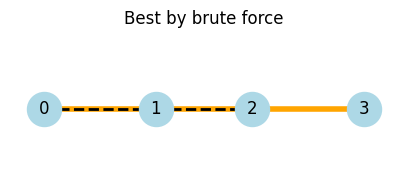

step 0 F= 0.9999999403953552
step 100 F= 0.9999999403953552
step 200 F= 0.9999999403953552
step 300 F= 0.9999999403953552
step 400 F= 0.9999999403953552
bestF 0.9999999403953552


In [1]:

import math, cmath, random, time
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
random.seed(0); np.random.seed(0); torch.manual_seed(0)

# Problem definition
# Variables order: [s01, s12, s23, bs01, bs12, bs23]  (6 binaries)
var_names = ['s01','s12','s23','bs01','bs12','bs23']
n = len(var_names)

# QUBO build
Q = np.zeros((n,n))
Q[0,0]=Q[1,1]=Q[2,2] = -1.0   # reward sources
Q[3,3]=Q[4,4]=Q[5,5] = -0.2   # bs
# synergies: if s01 and s23 both present they form matching (0,1)(2,3)
Q[0,2] = -0.8; Q[2,0] = -0.8
# matching (0,2)(1,3) would need diagonals; skip here
# source-bs synergies: connect each source to its BS
Q[0,3] = -0.7; Q[3,0] = -0.7
Q[1,4] = -0.7; Q[4,1] = -0.7
Q[2,5] = -0.7; Q[5,2] = -0.7
# BS conflicts
for i in [3,4,5]:
    for j in [3,4,5]:
        if i<j:
            Q[i,j]=0.4; Q[j,i]=0.4

# SA solver
def energy(x): xv=np.array(x); return float(xv @ Q @ xv)
def neighbor(x): y=x.copy(); i=random.randrange(len(x)); y[i]=1-y[i]; return y
def sa(Q, iters=4000):
    x=[random.choice([0,1]) for _ in range(n)]
    best=x.copy(); bestE=energy(x); curE=bestE
    for k in range(iters):
        y=neighbor(x); yE=energy(y)
        d=yE-curE
        T=1.0*(0.001**(k/iters))
        if d<0 or random.random() < math.exp(-d/max(T,1e-12)):
            x=y; curE=yE
            if curE<bestE:
                best=x.copy(); bestE=curE
    return best,bestE

# run SA and brute force
best_sa, e_sa = sa(Q, iters=6000)
print("SA best:", best_sa, e_sa)
# brute force
bestE=1e12; best=None
for v in range(1<<n):
    x=[(v>>i)&1 for i in range(n)]
    E=energy(x)
    if E<bestE: bestE=E; best=x
print("Brute best:",best, bestE)

# visualizing best skeleton
def draw_4mode(x, title=""):
    G=nx.Graph()
    G.add_nodes_from([0,1,2,3])
    pos={0:(-1,0.5),1:(-0.3,0.5),2:(0.3,0.5),3:(1,0.5)}
    sp=[]; bs=[]
    if x[0]: sp.append((0,1))
    if x[1]: sp.append((1,2))
    if x[2]: sp.append((2,3))
    if x[3]: bs.append((0,1))
    if x[4]: bs.append((1,2))
    if x[5]: bs.append((2,3))
    plt.figure(figsize=(5,2)); ax=plt.gca(); nx.draw_networkx_nodes(G,pos,node_color='lightblue',node_size=600); nx.draw_networkx_labels(G,pos)
    if sp: nx.draw_networkx_edges(G,pos,edgelist=sp,width=4,edge_color='orange')
    if bs: nx.draw_networkx_edges(G,pos,edgelist=bs,width=2,style='--',edge_color='black')
    plt.title(title); plt.axis('off'); plt.show()

draw_4mode(best,"Best by brute force")

# mapping: raw params = [r01,r12,r23, p01,p12,p23, m0,m1,m2,m3, t01,t12,t23] length 13
def torch_outputs(params):

    r01,r12,r23,p01,p12,p23,m0,m1,m2,m3,t01,t12,t23 = torch.unbind(params)
    P01 = torch.nn.functional.softplus(r01)
    P12 = torch.nn.functional.softplus(r12)
    P23 = torch.nn.functional.softplus(r23)
    c01 = torch.sqrt(P01)*torch.exp(1j*p01)
    c12 = torch.sqrt(P12)*torch.exp(1j*p12)
    c23 = torch.sqrt(P23)*torch.exp(1j*p23)
    # apply mode phases
    c01t = c01 * torch.exp(1j*(m0+m1))
    c12t = c12 * torch.exp(1j*(m1+m2))
    c23t = c23 * torch.exp(1j*(m2+m3))
    # toy mapping for matching amplitudes
    M1 = c01t * c23t
    M2 = c01t * c12t  # not physical—replace with correct mapping for real design
    M3 = c12t * c23t
    # normalize and fidelity (target = equal superposition)
    S = M1 + M2 + M3
    N = (torch.abs(M1)**2 + torch.abs(M2)**2 + torch.abs(M3)**2) + 1e-12
    F = (torch.abs(S)**2) / (3.0*N)
    return F, (M1,M2,M3), N

# example optimize the full graph
init = np.zeros(13); init[:3]=0.2; init[3:6]=0.0; init[6:10]=0.0; init[10:]=0.1
params = torch.tensor(init, dtype=torch.float32, requires_grad=True)
opt = torch.optim.Adam([params], lr=0.05)
bestF = -1e9; bestp=None
for step in range(500):
    opt.zero_grad(); F,Ms,N = torch_outputs(params); loss = 1.0-F; loss.backward(); opt.step()
    if F.item()>bestF: bestF=F.item(); bestp=params.detach().numpy().copy()
    if step%100==0:
        print("step",step,"F=",F.item())
print("bestF",bestF)

In [2]:
import numpy as np, math
best = bestp
r01,r12,r23,p01,p12,p23,m0,m1,m2,m3,t01,t12,t23 = best
# softplus -> positive pump
P01 = np.log1p(np.exp(r01))
P12 = np.log1p(np.exp(r12))
P23 = np.log1p(np.exp(r23))
# theta = 0.5 * math.pi * (1/(1+math.exp(-t_theta)))  # sigmoid mapping
print("Pumps:", P01, P12, P23)
print("Source phases:", p01, p12, p23)
print("Mode phases:", m0, m1, m2, m3)
# print("BS theta (rad):", theta)

Pumps: 0.79813886 0.79813886 0.79813886
Source phases: 0.0 0.0 0.0
Mode phases: 0.0 0.0 0.0 0.0


In [3]:
params = torch.tensor(best, dtype=torch.float32, requires_grad=True)
F,_,_ = torch_outputs(params)
F.backward()
grads = params.grad
print("grad norms per param:", [float(abs(g).item()) for g in grads])
print("total grad norm:", float(torch.norm(grads).item()))

grad norms per param: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
total grad norm: 0.0


In [4]:
import numpy as np
base = best.copy()
deltas = np.linspace(-0.1,0.1,9)
Fs = []
for d in deltas:
    test = base.copy()
    test[6] += d   # perturb mA (mode phase)
    Ft,_,_ = torch_outputs(torch.tensor(test, dtype=torch.float32))
    Fs.append(float(Ft))
print(list(zip(deltas, Fs)))

[(np.float64(-0.1), 0.9977796673774719), (np.float64(-0.07500000000000001), 0.9987506866455078), (np.float64(-0.05), 0.9994446039199829), (np.float64(-0.024999999999999994), 0.9998611211776733), (np.float64(0.0), 0.9999999403953552), (np.float64(0.024999999999999994), 0.9998611211776733), (np.float64(0.05000000000000002), 0.9994446039199829), (np.float64(0.07500000000000001), 0.9987506866455078), (np.float64(0.1), 0.9977796673774719)]
